<a href="https://colab.research.google.com/github/vaguiar/camelyon_dl_2019/blob/data-exploration/generate_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install tf-nightly-2.0-preview
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

     |████████████████████████████████| 87.5MB 1.2MB/s 
     |████████████████████████████████| 61kB 20.1MB/s 
     |████████████████████████████████| 3.1MB 9.8MB/s 
     |████████████████████████████████| 430kB 39.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import io
# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required


%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

You have version 2.0.0-dev20190512


In [4]:
## load data fom google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GCP_PROJECT_ID = 'triple-voyage-239123'
GCP_BUCKET_NAME = 'vaa2114_dl_2019'

In [6]:
!gcloud config set project {GCP_PROJECT_ID}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [7]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"model/"} {"/tmp"}

Copying gs://vaa2114_dl_2019/model/level3_window_800.h5...
Copying gs://vaa2114_dl_2019/model/level5_window_400.h5...
\ [2/2 files][151.6 MiB/151.6 MiB] 100% Done                                    
Operation completed over 2 objects/151.6 MiB.                                    


In [0]:
LEVEL = 5

TEST_DIR = "/tmp/validate/"
GCP_TEST_DIR = "validate/level{}/".format(LEVEL)
LEVEL_TEST_DIR = "/tmp/validate/level{}".format(LEVEL)

In [0]:
!rm -rf '$TEST_DIR'

!mkdir -p '$TEST_DIR'

In [0]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TEST_DIR} {TEST_DIR}
  
print("\nDownloaded Test Data")

print("# Non Tumor files")
!ls "$LEVEL_TEST_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_TEST_DIR/tumor/" | wc -l

In [0]:
elements = os.listdir(os.path.join(LEVEL_TEST_DIR, "tumor"))[0].split("_")
LEVEL = elements[1]
WINDOW = elements[4]

In [0]:
base_dir = "tmp/slides"
def getSlide_Mask(slide_file, tumor_mask_file):

  

  slide = open_slide(slide_file)
  tumor_mask = open_slide(tumor_mask_file)
  
  # some slides have more than 8 levels, since we will only use the first 8 levels 
  # we will only assert that the first 8 levels have the appropriate dimensions 
  for i in range(8):  
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide, tumor_mask

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
  
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [13]:
slide_path = elements[5] + "_" + elements[6]
tumor_mask_path = elements[5] + "_" + elements[6].split('.')[0]+'_mask.tif'

print(slide_path, tumor_mask_path)

tumor_101.tif tumor_101_mask.tif


In [0]:
slide_file= '/content/drive/My Drive/tumor_101.tif'
tumor_mask_file  = '/content/drive/My Drive/tumor_101_mask.tif'

  
slide, tumor_mask = getSlide_Mask(slide_file, tumor_mask_file)

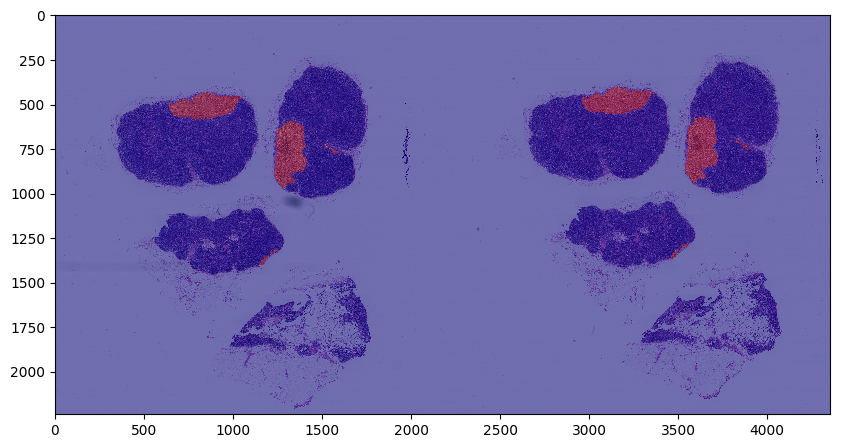

In [30]:
slide_image_orig = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = mask_image_orig[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_orig)
plt.imshow(mask_image_orig, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [46]:
slide.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)

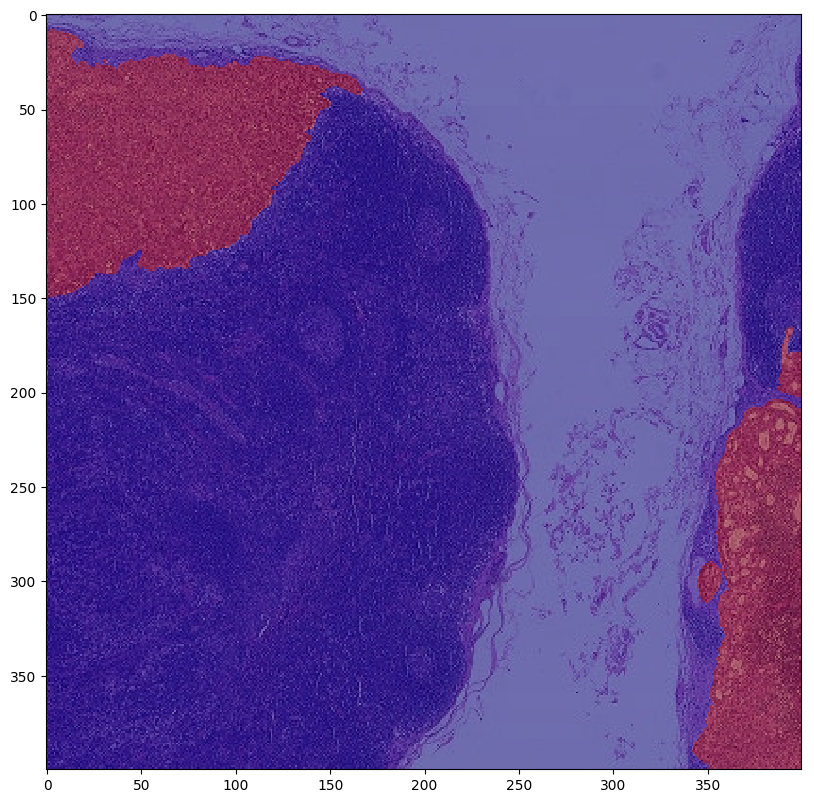

In [75]:
X = 102400
Y = 12800
WINDOW = 400

slide_image = read_slide(slide, 
                         x=X, 
                         y=Y, 
                         level=5, 
                         width=WINDOW, 
                         height=WINDOW)

mask_image = read_slide(tumor_mask, 
                         x=X, 
                         y=Y, 
                         level=5, 
                         width=WINDOW, 
                         height=WINDOW)

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

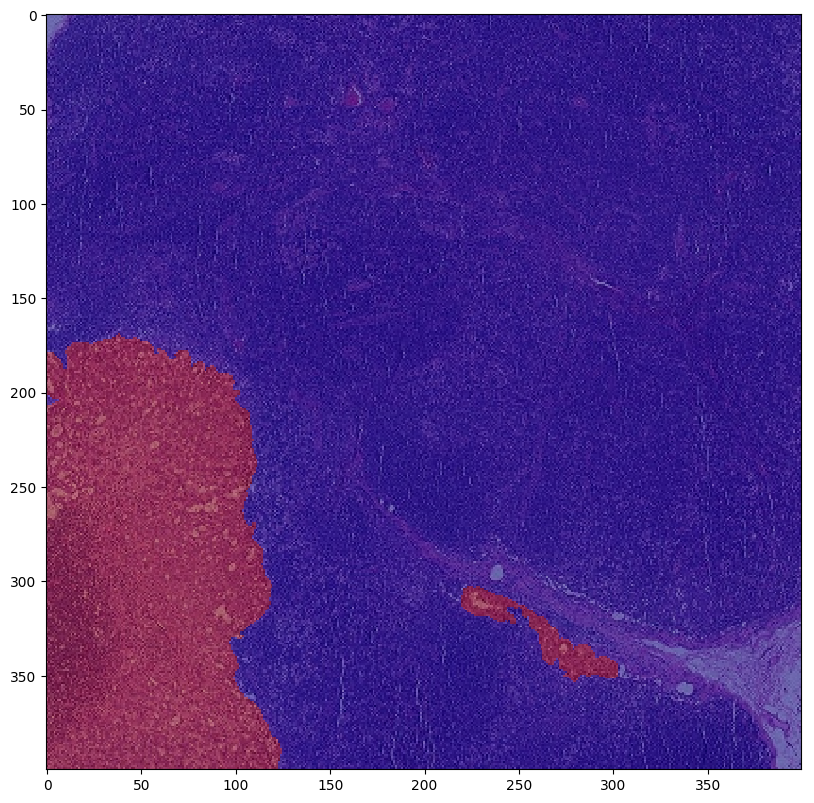

In [86]:
X = 102400 + 400*int(down_samples)
Y = 12800 
WINDOW = 400

slide_image = read_slide(slide, 
                         x=X, 
                         y=Y, 
                         level=5, 
                         width=WINDOW, 
                         height=WINDOW)

mask_image = read_slide(tumor_mask, 
                         x=X, 
                         y=Y, 
                         level=5, 
                         width=WINDOW, 
                         height=WINDOW)

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [73]:
x_down, y_down

(3200, 1200)

In [0]:
def modify_heat_map(x,y,downsample_factor, window):
    x_down = int(x/downsample_factor)
    y_down = int(y/downsample_factor)
    for x in range(x_down, x_down+window):
      for y in range (y_down, y_down+window):
        heat_map[y][x] = 1 
    return heat_map

In [0]:
heat_map = slide_image_orig[:,:,0]*0

In [35]:
tumors = os.listdir('/tmp/validate/level5/tumor')
tumors = [s for s in tumors if "101" in s]
tumors

['level_5_102400_25600_400_tumor_101.tif',
 'level_5_102400_38400_400_tumor_101.tif',
 'level_5_38400_25600_400_tumor_101.tif',
 'level_5_102400_12800_400_tumor_101.tif',
 'level_5_89600_12800_400_tumor_101.tif',
 'level_5_38400_12800_400_tumor_101.tif',
 'level_5_38400_38400_400_tumor_101.tif',
 'level_5_115200_12800_400_tumor_101.tif',
 'level_5_25600_12800_400_tumor_101.tif',
 'level_5_25600_38400_400_tumor_101.tif',
 'level_5_12800_12800_400_tumor_101.tif',
 'level_5_115200_25600_400_tumor_101.tif']

In [0]:
down_samples = slide.level_downsamples[int(LEVEL)]
heat_map = slide_image_orig[:,:,0]*0

for tum in tumors: 
  elements = tum.split('_')
  X = int(elements[2])
  Y = int(elements[3])
  window = int(elements[4])

  heat_map = modify_heat_map(X, Y, down_samples, window)

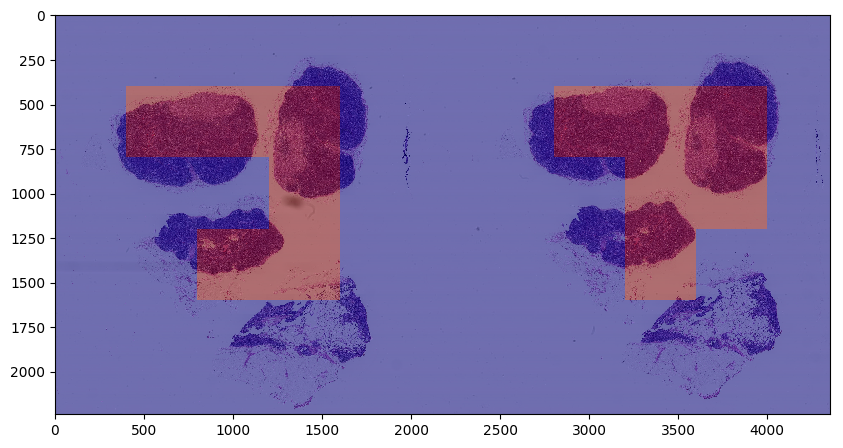

In [90]:
slide_image_orig = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_orig)
plt.imshow(heat_map, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
np.shape(mask_image)